In [1]:
import sys
sys.path.append("../")

import numpy as np
import ROOT
import matplotlib.pyplot as plt
import pandas as pd

# load the macro functions we want to use to create the branches 
# we want on the filtered RDFs
# from rootMacros import makeROOTFunctions
# makeROOTFunctions()

Welcome to JupyROOT 6.27/01


### Tile Setup

In [2]:
# each asic is 4x4 channels
channelXdim = 4
channelYdim = 4

# each tile is 8x8 ASIC array
arrayXdim = 16 # 8
arrayYdim = 16 # 8

xMAX = 575 # from metadata tree, 11.979 tiles in this direction..
xMIN = 1
yMAX = 1500 # from metadata tree, 31.25 tiles in this direction..
yMIN = 1


xDIM = arrayXdim * channelXdim
yDIM = arrayYdim * channelYdim

In [3]:
ROOT.EnableImplicitMT()
rdf = ROOT.RDataFrame("event_tree", "../../data_radiogen/1ks_fix/core_0_rtd_input_rtd.root")
print("opened rdf of entries: ", rdf.Count().GetValue())

ROOT.gStyle.SetOptStat(0) # remove the histo box over the label

max_x = rdf.Max("pixel_x").GetValue()
max_y = rdf.Max("pixel_y").GetValue()

min_x = rdf.Min("pixel_x").GetValue()
min_y = rdf.Min("pixel_y").GetValue()
print(f"obtained range: ({min_x}-{max_x}:{min_y}-{max_y})")

colNames = rdf.GetColumnNames()
print("found columns: ", colNames)

opened rdf of entries:  84302142
obtained range: (0.0-575.0:0.0-1500.0)
found columns:  { "pixel_reset", "pixel_reset_truth_track_id", "pixel_reset_truth_weight", "pixel_x", "pixel_y" }


## Data Extraction
place into electron pie graph
find average RTD for all inputs
find average RTD for isotopes that were the major factor of the rtd

displaying resets in all channels


Info in <TCanvas::Print>: png file ./pdfs/fullApaResets_noise.png has been created


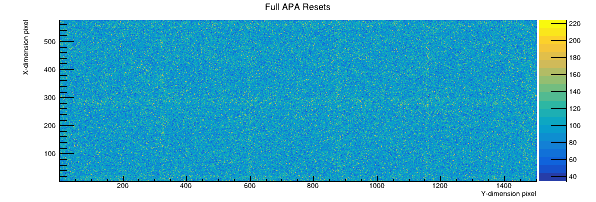

In [4]:
print("displaying resets in all channels")
c = ROOT.TCanvas("c1", "c1", 600, 230)
h = rdf.Histo2D(("h", "ht", 1500, 0.5, 1500.5, 575, 0.5, 575.5), "pixel_y", "pixel_x")
h.Draw("colz")
h.SetTitle("Full APA Resets")
c.Draw()
h.GetXaxis().SetTitle("Y-dimension pixel")
h.GetYaxis().SetTitle("X-dimension pixel")
c.SaveAs("./pdfs/fullApaResets_noise.png")
# ROOT.c1.Draw()
# h = savehist(h)

4
575.0 1500.0
374.75
143.75 375.0 35.75


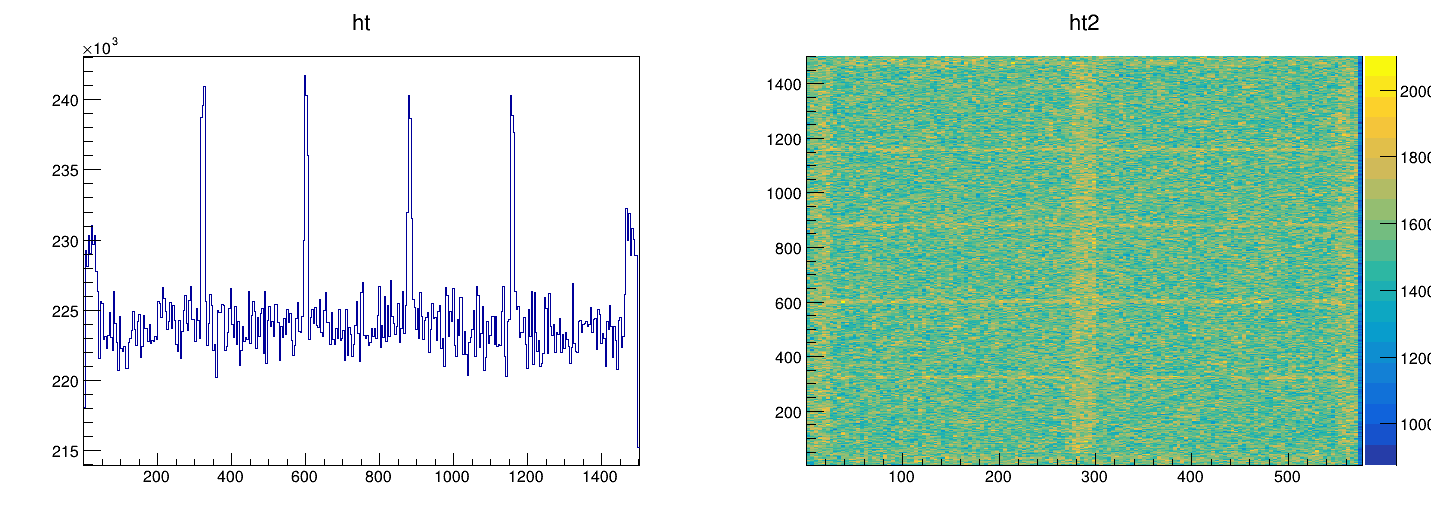

In [5]:
c = ROOT.TCanvas("c", "c", 1450, 550)
c.Divide(2,1)
c.cd(1)
print(channelYdim)
print(max_x, max_y)
print(1499/channelYdim)
print(575/channelXdim, 1500/channelYdim, 143/channelYdim)
h = rdf.Histo1D(("h", "ht", 375, 0.5, 1500.5), "pixel_y")
h.Draw("colz")
c.cd(2)
h2 = rdf.Histo2D(("h2", "ht2", 144, 0.5, 576.5, 375, 0.5, 1500.5), "pixel_x", "pixel_y")
h2.Draw("colz")
c.Draw()

## Show the electron and reset densities

Info in <TCanvas::Print>: pdf file ./pdfs/pixel_reset_truth_weight_noise.pdf has been created
Info in <TCanvas::Print>: pdf file ./pdfs/pixel_reset_truth_track_id_noise.pdf has been created


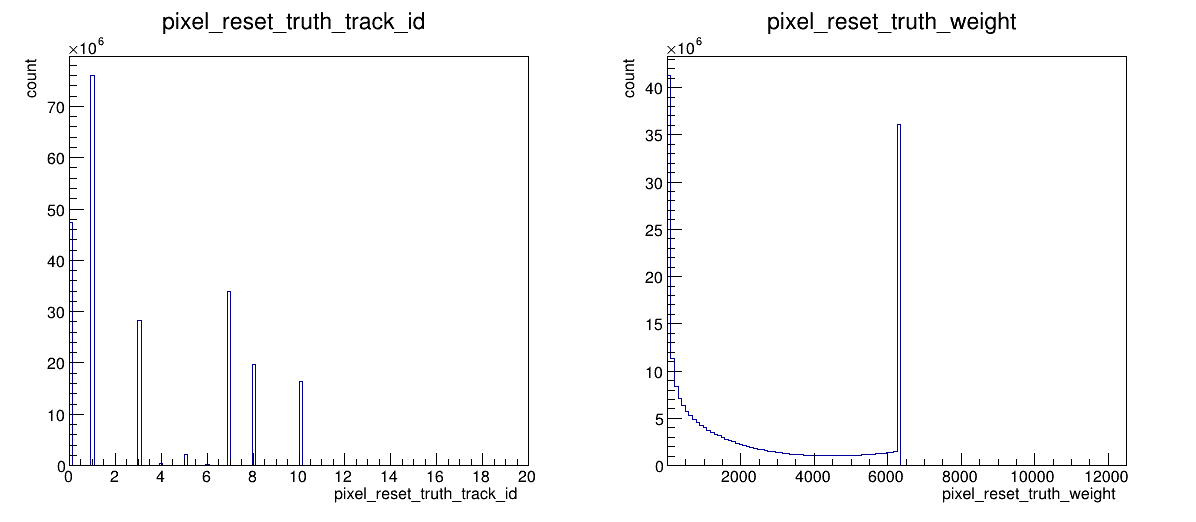

In [6]:
def showElectrons(input_df):
    """
    """
    fdf = input_df.Filter("pixel_x != 0 && pixel_y != 0")
    
    # must keep the canvas and hist objects alive to display
    cv = ROOT.TCanvas("cv", "cv", 1200, 550)
    cv.Divide(2)
    
    cv.cd(1) 
    hs = fdf.Histo1D("pixel_reset_truth_track_id")
    hs.Draw()
    

    cv.cd(2)
    hs_w = fdf.Histo1D("pixel_reset_truth_weight")
    hs_w.Draw()
    
    cv.Draw()
    # save this histograms to /pdfs/
    _tmpHs_w = ROOT.TCanvas("tmp", "tmp", 550, 550)
    hs_w.Draw()
    _tmpHs_w.Draw()
    _tmpHs_w.SaveAs("./pdfs/pixel_reset_truth_weight_noise.pdf")
    
    _tmpHs = ROOT.TCanvas("trk", "trk", 550, 550)
    hs.Draw()
    _tmpHs.Draw()
    _tmpHs.SaveAs("./pdfs/pixel_reset_truth_track_id_noise.pdf")
    return cv, hs, hs_w

if True:
    b = showElectrons(rdf)

In [7]:
def makeWeight(input_df):
    """
    take the base input dataframe, and make sure that we don't have
    any impossible track_ids
    make the responsible defines
    """
    names = ["Ar39", "Ar42", "Bi214", "Co60", "K40", "K42", "Kr85", "Pb214", "Po210", "Rn222"]
    print("creating column names: ", names)
    fdf = input_df.Filter("pixel_x != 0 && pixel_y != 0")
    for name in names:
        fdf = fdf.Define(f"{name}", f"defineBranch(\"{name}\", pixel_reset_truth_weight, pixel_reset_truth_track_id)")
    
    ce = ROOT.TCanvas("ce", "ce", 1200, 2550)
    hs = []
    ce.Divide(2,5)
    for i, name in enumerate(names):
        ce.cd(i+1)
        tdf = fdf.Filter(f"{name} > 0")
        print(f"{name} has counts: ", tdf.Count().GetValue()) 
        hs.append(tdf.Histo1D(f"{name}"))
        hs[-1].Draw()
        

    ce.Draw()
    return ce, hs

if False:
    b = makeWeight(rdf)

## Find the most active tile, and convert this into a json file for further simulation

In [8]:
def findActiveRegion(input_rdf, arrayXdim=arrayXdim, arrayYdim=arrayYdim):

    # scan through the detector volume
    xITR = range(xMIN, xMAX, xDIM)
    yITR = range(yMIN, yMAX, yDIM)

    # lots of zero positions
    bestPos = 0
    bestX, bestY = 0, 0
    for x in xITR:
        for y in yITR:
            fdf = input_rdf.Filter(f"pixel_x >= {x} && pixel_x < {x+xDIM}")\
                           .Filter(f"pixel_y >= {y} && pixel_y < {y+yDIM}")
            nResets = fdf.Count().GetValue()
            if nResets > bestPos:
                bestPos = nResets
                bestX = x
                bestY = y
    return bestX, bestY, bestPos

In [9]:
if False:
    bestX, bestY, bestPos = findActiveRegion(rdf)
    print(f"found most active position: ({bestX},{bestY}) with {bestPos} hits")
else:
    bestX = 281
    bestY = 561
    bestPos = 205640

fdf = rdf.Filter(f"pixel_x >= {bestX} && pixel_x < {bestX+xDIM}")\
         .Filter(f"pixel_y >= {bestY} && pixel_y < {bestY+yDIM}")

In [10]:
def makeNumpy(filtered_df, time_start=0, time_end=None):
    from math import ceil

    rd_data = filtered_df.AsNumpy(["pixel_x", "pixel_y", "pixel_reset"])
    
    pixel_x = rd_data["pixel_x"]
    pixel_y = rd_data["pixel_y"]
    pixel_reset = rd_data["pixel_reset"]
    
    if time_end is not None:
        good_times = np.logical_and(pixel_reset > time_start, pixel_reset <= time_end)
        pixel_x = pixel_x[good_times]
        pixel_y = pixel_y[good_times]
        pixel_reset = pixel_reset[good_times]
    
    pd_data = {}
    pd_data["pX"] = pixel_x
    pd_data["pY"] = pixel_y
    pd_data["Reset"] = pixel_reset

    df = pd.DataFrame(pd_data)
    # count these as done in Simulation "Top Left" Asic is (0,0) : (row, col)
    # create X
    df['tileX'] = ((df['pX'] - 1) / xDIM).map(int)
    df["AsicX"] = ((df["pX"] - 1) / channelXdim).map(int)

    # create Y
    df['tileY'] = ((df['pY'] - 1) / yDIM).map(int)
    df["AsicY"] = ((df["pY"] - 1) / channelYdim).map(int)

    # create N, unique ASIC / Tile numbers to easily histogram
    df['tileN'] = df['tileX'] + df['tileY'] * ceil(xMAX / xDIM)
    df['AsicN'] = df['AsicX'] + df['AsicY'] * ceil(xMAX / channelXdim)

    # for each asic, it should only number a nPix within it's dimensions channelXdim *channelYdim
    # we chose X-dim as the "row" and Y-dim as the "column", to be consistent with the 
    # coordinates for the tile / simulation dimensions
    npx = ((df["pX"]) - channelXdim*df["AsicX"] - 1).map(int)
    npy = ((df["pY"]) - channelYdim*df["AsicY"] - 1).map(int)
    df["nPix"] = npx + channelYdim*npy
    df["PixN"] = df['pX'] + (df['pY'] ) * xMAX # include -1 since pY is one counted
    
    return df

out_file = "/mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data.json"
def makeJson(filtered_df, arrayXdim=arrayXdim, arrayYdim=arrayYdim, outf=out_file, time_start=0, time_end=None):
    """
    args: filtered_pd_df - filtered RDataFrame
    """
    fdf = makeNumpy(filtered_df, time_start, time_end)
    
    # create the tile's dataframe to send into the QPixAsicArray
    tiledf = {}
    tiledf["nrows"] = arrayXdim
    tiledf["ncols"] = arrayYdim
    tiledf["hits"] = []

    # normalize asic numbers: this is for the simulation input which "0 numbers" the asic's within it's rows / cols
    hitX = fdf["AsicX"].unique()
    hitY = fdf["AsicY"].unique()
    minX = min(hitX)
    minY = min(hitY)

    # build the hits tuple for each asic within the tile
    nHits = 0
    for x in hitX:
        for y in hitY:
            asicResets = fdf[ (fdf["AsicX"] == x) & (fdf["AsicY"] == y) ][["Reset","nPix"]].values.tolist()
            arrayX = x if minX == 0 else int(x%minX)
            arrayY = y if minY == 0 else int(y%minY)
            if time_end is not None:
                asicResets = np.array(asicResets) - time_start
                asicResets = asicResets.tolist()
            tiledf["hits"].append([arrayX, arrayY, list(asicResets)])
            nHits += len(asicResets)

    print("creating file with hits:", nHits)        
    # store the values within a json file
    import json
    with open(outf, "w") as outputFile:
        json.dump(tiledf, outputFile, indent=4)
        print("saved file", outf)
        outputFile.close()

In [11]:
out_file = "/mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data_200-210.json"
if True:
    makeJson(fdf)
    makeJson(fdf, outf=out_file, time_start=200, time_end=210)

creating file with hits: 411152
saved file /mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data.json
creating file with hits: 4281
saved file /mnt/c/Users/keefe/OneDrive/Documents/root_temp/jsons/1k_rtd_data_200-210.json


In [12]:
import codecs, json
import QpixAsicArray as qparray
from QpixAsicArray import PrintTransactMap

## based on ArrayNotebook.ipynb
def getDF(input_file):
    obj_text = codecs.open(input_file, 'r').read()
    return json.loads(obj_text)

testDF = getDF(out_file)

qpa = qparray.QpixAsicArray(0, 0, tiledf=testDF, debug=0)
qpa.Route(route="snake", timeout=15e3, transact=False)

TIMESTOP = 10
intfrq = 0.5
intHard = 10 # hard interrogate every 20s
int_period = np.linspace(0, TIMESTOP, int(TIMESTOP/intfrq))
for i in range(len(int_period)+1):
    useHard = bool(int(i)%intHard==0) 
    qpa.Interrogate(intfrq, hard=useHard)

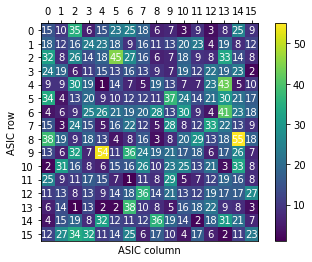

In [13]:
from QpixAsicArray import heatMap

transactData = PrintTransactMap(qpa, silent=True)

# # build up 2d array of transactions to store in heat maps
localData = np.zeros((qpa._nrows, qpa._ncols), dtype=np.int32)
localT = transactData["LocalT"]
for i, j, T in localT:
    localData[i][j] = T

remoteDataT = np.zeros((qpa._nrows, qpa._ncols), dtype=np.int32)
remoteT = transactData["RemoteT"]
for i, j, T in remoteT:
    remoteDataT[i][j] = T

remoteDataM = np.zeros((qpa._nrows, qpa._ncols), dtype=np.int32)
remoteM = transactData["RemoteMax"]
for i, j, T in remoteM:
    remoteDataM[i][j] = T
    
fig, ax = plt.subplots()
heatMap(localData, qpa._nrows, qpa._ncols, ax=ax)
ax.set_xlabel("ASIC column")
ax.set_ylabel("ASIC row")
fig.savefig("./pdfs/localHitsRadiogenic_noise.pdf")

### Show RTDs of this tile

In [14]:
data = fdf.AsNumpy()
print(data.keys())

resets = data['pixel_reset']
pix_x = data['pixel_x']
pix_y = data['pixel_y']

uniq_pix_x = np.unique(pix_x)
uniq_pix_y = np.unique(pix_y)

tmp_resets = []
for x in uniq_pix_x:
    for y in uniq_pix_y:
        pix_resets = resets[np.logical_and(pix_x == x, pix_y == y)]
        tmp_resets.append(sorted(pix_resets))
        
def makeRTD(arr):
    rtd_arr = np.array([ arr[i+1] - arr[i] for i in range(len(arr)-1) ])
    return rtd_arr

pix_size = len(uniq_pix_x) * len(uniq_pix_y) 
rtds = [ makeRTD(tr) for tr in tmp_resets ]
print("pixel sizes:", pix_size)
print("uniq_x:", len(uniq_pix_x))
print("uniq_y:", len(uniq_pix_y))

dict_keys(['pixel_reset', 'pixel_reset_truth_track_id', 'pixel_reset_truth_weight', 'pixel_x', 'pixel_y'])
pixel sizes: 4096
uniq_x: 64
uniq_y: 64


[0.000e+00 1.000e+00 2.000e+00 ... 4.093e+03 4.094e+03 4.095e+03]
4096


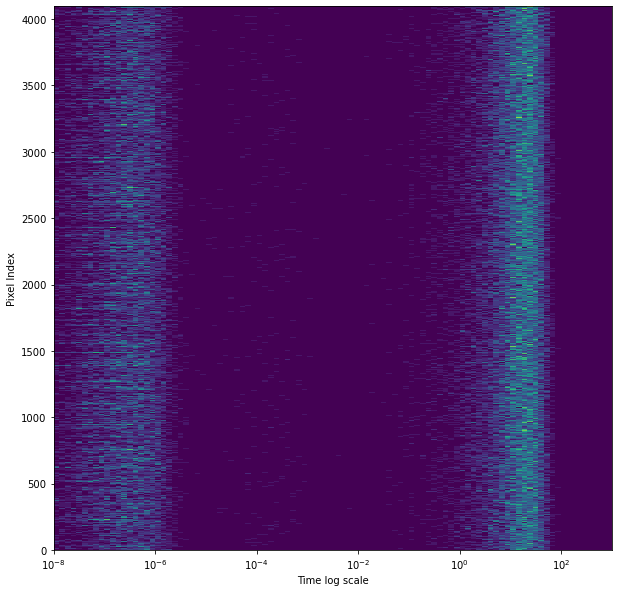

In [15]:
# canv = ROOT.TCanvas("c", "c", 1000, 1000)
pix_bins = np.arange(0, pix_size, dtype=np.double)
time_bins = np.logspace(-8, 3, dtype=np.double, num=100)

print(pix_bins)
print(len(rtds))

# th2 = ROOT.TH2D("h", "h", len(time_bins), time_bins, pix_size, pix_bins)
rs = []
iss = []
for i, rtd in enumerate(rtds):
    for r in rtd:
        rs.append(r)
        iss.append(i)

plt.figure(figsize=(10,10))
plt.semilogx(True)
plt.hist2d(rs, iss, bins=[time_bins, pix_bins])
plt.xlabel("Time log scale")
plt.ylabel("Pixel Index")
plt.savefig("./pdfs/radiogenicRTDtimescale_noise.pdf")

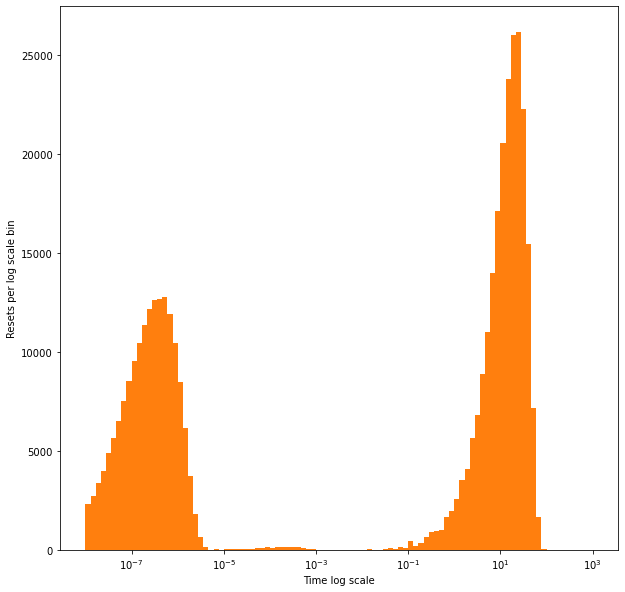

In [16]:
plt.figure(figsize=(10,10))
plt.semilogx(True)
plt.hist(rs, bins=time_bins)
plt.xlabel("Time log scale")
plt.ylabel("Resets per log scale bin")
plt.savefig("./pdfs/radiogenicRTDtimescale_1d_noise.pdf")

total sets: 411152
407056 407056
Noise 2.454164e+08
Ar39 1.627245e+09
Ar42 1.601550e+05
Bi214 1.795852e+08
Co60 5.119030e+05
K40 9.091549e+07
K42 1.489692e+06
Kr85 2.154643e+08
Pb214 7.951044e+07
Po210 1.259400e+04
Rn222 1.037889e+08


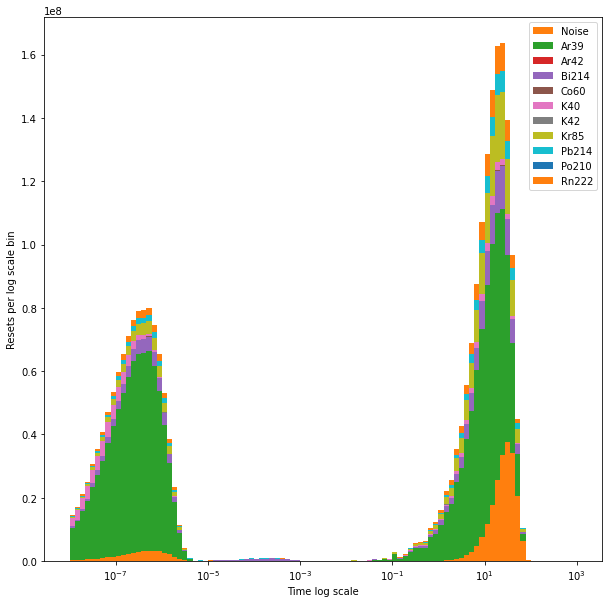

In [58]:
resets = data['pixel_reset']
print("total sets:", len(resets))
pix_x = data['pixel_x']
pix_y = data['pixel_y']
reset_ids = data['pixel_reset_truth_track_id']
reset_weights = data['pixel_reset_truth_weight']

uniq_pix_x = np.unique(pix_x)
uniq_pix_y = np.unique(pix_y)

flat_ids = [ nid for ids in reset_ids for nid in ids]
uniq_ids = np.unique(flat_ids)

tmp_resets, tmp_ids, tmp_weights = [], [], []
for x in uniq_pix_x:
    for y in uniq_pix_y:
        pix_ids = np.logical_and(pix_x == x, pix_y == y)
        pix_resets = resets[pix_ids]
        pix_weights = reset_weights[pix_ids]
        pix_ids = reset_ids[pix_ids]
        
        sort_pix_resets, sort_pix_weights, sort_pix_ids = zip(*sorted(zip(pix_resets, pix_weights, pix_ids)))
        
        tmp_resets.append(sort_pix_resets)
        tmp_weights.append(sort_pix_weights)
        tmp_ids.append(sort_pix_ids)
        
def makeRTD(arr):
    rtd_arr = np.array([ arr[i+1] - arr[i] for i in range(len(arr)-1) ])
    return rtd_arr

# pix_size = len(uniq_pix_x) * len(uniq_pix_y) 
rtds = [ makeRTD(tr) for tr in tmp_resets ]
ids = [ idd[1:] for idd in tmp_ids ]
weights = [ weight[1:] for weight in tmp_weights]

# flatten the resets
flat_rtds = [ r for pix_r in rtds for r in pix_r ]
flat_ids = [ idd for pix_idd in ids for idd in pix_idd ]
flat_weights = [ weight for pix_weight in weights for weight in pix_weight ]

print(len(flat_rtds), len(flat_ids))

# notes                      B-0.5   0.5   3.3MeV  0.3 MeV 1.3MeV  3.5MeV  0.7MeV  1.0MeV  alpha@5.4  alpha@5.59
uniq_ids_labels = ["Noise", "Ar39", "Ar42", "Bi214", "Co60", "K40", "K42", "Kr85", "Pb214", "Po210", "Rn222"]

energy_dep_id = []

reset_stacks = []
reset_weights = []
for i, uids in enumerate(uniq_ids):
    
    id_resets = [ rtd for rtd, ids in zip(flat_rtds, flat_ids) if uids in ids ]
    reset_stacks.append(id_resets)
    
    w_resets = [ w for weights, ids in zip(flat_weights, flat_ids) for w, idd in zip(weights, ids) if idd == uids ]
    reset_weights.append(w_resets)

    energy_dep = np.mean(w_resets)*len(id_resets)
    energy_dep_id.append(energy_dep)
    print(uniq_ids_labels[i], f"{energy_dep:02e}")


plt.figure(figsize=(10,10))
plt.semilogx(True)
plt.hist(reset_stacks, bins=time_bins, stacked=True, weights=reset_weights, label=uniq_ids_labels)
plt.xlabel("Time log scale")
plt.ylabel("Resets per log scale bin")
plt.legend()
plt.savefig("./pdfs/radiogenicRTDtimescale_stack_1d_noise.pdf")

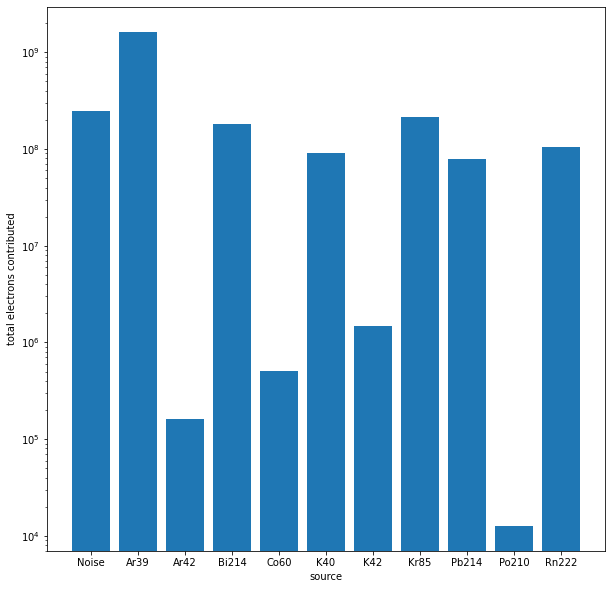

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_yscale('log')
ax.bar(uniq_ids, energy_dep_id)
ax.set_xticks(np.arange(11), labels=uniq_ids_labels)
ax.set_ylabel("total electrons contributed")
ax.set_xlabel("source")
plt.savefig("./pdfs/sim_electron_contribution_log.pdf")

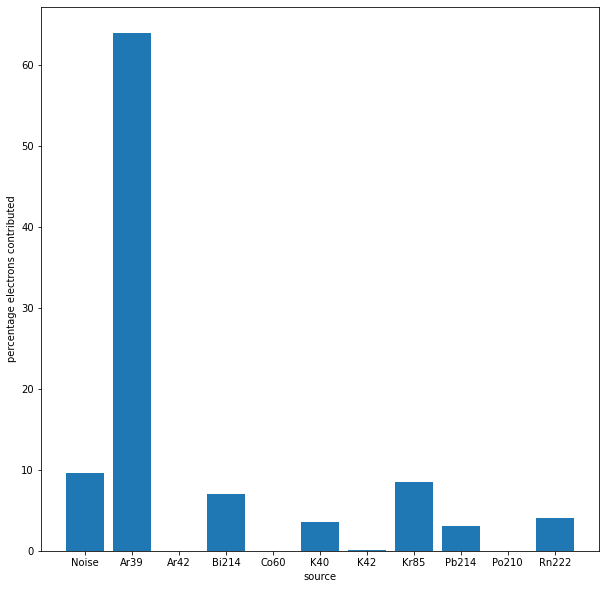

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
benergy_dep_id = energy_dep_id/np.sum(energy_dep_id)*100
ax.bar(uniq_ids, benergy_dep_id)
ax.set_xticks(np.arange(11), labels=uniq_ids_labels)
ax.set_ylabel("percentage electrons contributed")
ax.set_xlabel("source")
plt.savefig("./pdfs/sim_electron_contribution_percent.pdf")

In [89]:
1000/(411152/4096)

9.962252403004241

In [80]:
print("pb214 perc: ", energy_dep_id[8]/np.sum(energy_dep_id[1:]))
print("Bi214 perc: ", energy_dep_id[3]/np.sum(energy_dep_id[1:]))
print("k40 perc: ", energy_dep_id[5]/np.sum(energy_dep_id[1:]))

pb214 perc:  0.03458955298417094
Bi214 perc:  0.07812524683965136
k40 perc:  0.03955111105536133


In [82]:
m = 7000*3272.11
print("pb214 dep: ", 7000*1024.11/m)
print("Bi214 dep: ", m/m)
print("k40 dep: ", 12642*1340/m)

pb214 dep:  0.31298153179446897
Bi214 dep:  1.0
k40 dep:  0.739596162720691
